# Maintenance Requests Forecasting with Deep Learning

## Import Libraries

In [52]:
# Processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Visualization
import matplotlib.pyplot as plt

## Load Data

In [2]:
dataset_raw = pd.read_csv(r'data\data_raw.csv')
dataset_processed = dataset_raw.copy()

In [3]:
dataset_raw.head()

,data_cadastro,requisicoes
0,2016-10-10,1
1,2016-10-13,3
2,2016-10-14,1
3,2016-10-17,2
4,2016-10-19,1


In [4]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_cadastro  704 non-null    object
 1   requisicoes    704 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


## Data Preparation

### Converter data_cadastro para o tipo datetime

In [5]:
dataset_processed['data_cadastro'] = pd.to_datetime(dataset_processed['data_cadastro'], format='%Y-%m-%d')
print('data_cadastro type:', dataset_processed['data_cadastro'].dtype)

data_cadastro type: datetime64[ns]


### Armazenando a data de início e fim da série temporal

In [6]:
date_start = dataset_processed['data_cadastro'].min()
date_end = dataset_processed['data_cadastro'].max()
print('Início da série temporal:', date_start)
print('Fim da série temporal:', date_end)

Início da série temporal: 2016-10-10 00:00:00
Fim da série temporal: 2023-10-25 00:00:00


### Preencher a série temporal 

In [7]:
# Crie um DataFrame com todas as datas no intervalo desejado.
datas_todas = pd.date_range(start=date_start, end=date_end, freq='D')

# Defina a coluna 'data' como o índice do DataFrame.
dataset_processed.set_index('data_cadastro', inplace=True)

# Junte (merge) os DataFrames para adicionar os registros ausentes.
# Use 'outer' para incluir todas as datas e preencher os valores ausentes com 0.
dataset_processed = datas_todas.to_frame().merge(dataset_processed, left_index=True, right_index=True, how='outer')

# Preencha os valores ausentes com 0.
dataset_processed['requisicoes'].fillna(0, inplace=True)

In [9]:
print('dataset_raw shape:', dataset_raw.shape)
print('dataset_processed shape:', dataset_processed.shape)

dataset_raw shape: (704, 2)
dataset_processed shape: (2572, 2)


In [14]:
dataset_processed  = dataset_processed.drop([0], axis=1)
dataset_processed.head()

,requisicoes
2016-10-10,1.0
2016-10-11,0.0
2016-10-12,0.0
2016-10-13,3.0
2016-10-14,1.0


### Univariate Time Series Reframe for Multi-step Forecasting with LSTM Models 

#### Split into Samples

In [25]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
    
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [35]:
n_steps_in = 30
n_steps_out = 30
X, y = split_sequence(list(dataset_processed['requisicoes']),n_steps_in,n_steps_out)
print('X shape:',X.shape)
print('y shape:',y.shape)

X shape: (2513, 30)
y shape: (2513, 30)


In [36]:
for i in range(3):
    print(f'X{i}:', X[i])
    print(f'y{i}:', y[i])

X0: [1. 0. 0. 3. 1. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 2. 1. 0. 0. 3. 1.]
y0: [1. 0. 0. 0. 0. 3. 0. 0. 3. 1. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 4. 0.]
X1: [0. 0. 3. 1. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2.
 1. 0. 0. 3. 1. 1.]
y1: [0. 0. 0. 0. 3. 0. 0. 3. 1. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 4. 0. 1.]
X2: [0. 3. 1. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 1.
 0. 0. 3. 1. 1. 0.]
y2: [0. 0. 0. 3. 0. 0. 3. 1. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 4. 0. 1. 0.]


#### Reshape Subsequences

In [38]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

## Data Segragation

In [44]:
# 60% / 20% / 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print()
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print()
print('X_test shape:', X_val.shape)
print('y_test shape:', y_val.shape)

X_train shape: (1884, 30, 1)
y_train shape: (1884, 30)

X_val shape: (629, 30, 1)
y_val shape: (629, 30)

X_test shape: (629, 30, 1)
y_test shape: (629, 30)


## Modeling

### Define the model

In [48]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in,n_features)))
model.add(Dense(n_steps_out, activation='relu'))

### Compile the model

In [49]:
model.compile(optimizer='adam', loss='mse')

### fit the model

In [50]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)

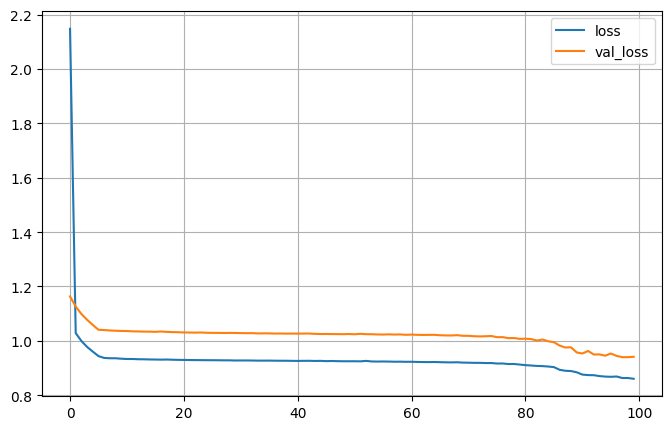

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Results

In [57]:
X_test.shape

(503, 30, 1)

In [64]:
y_test[0].shape

(30,)

1/1 [==============================] - 0s 31ms/step


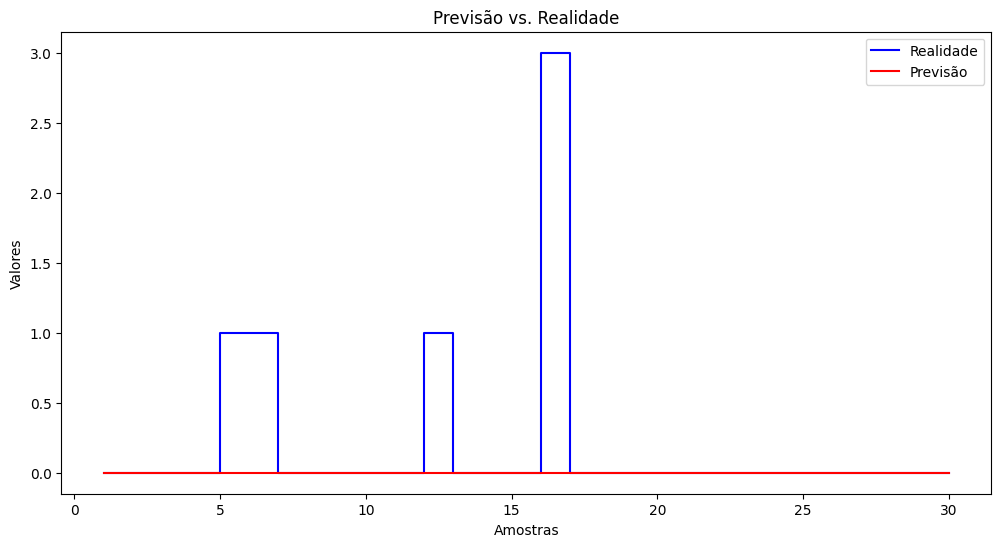

1/1 [==============================] - 0s 24ms/step


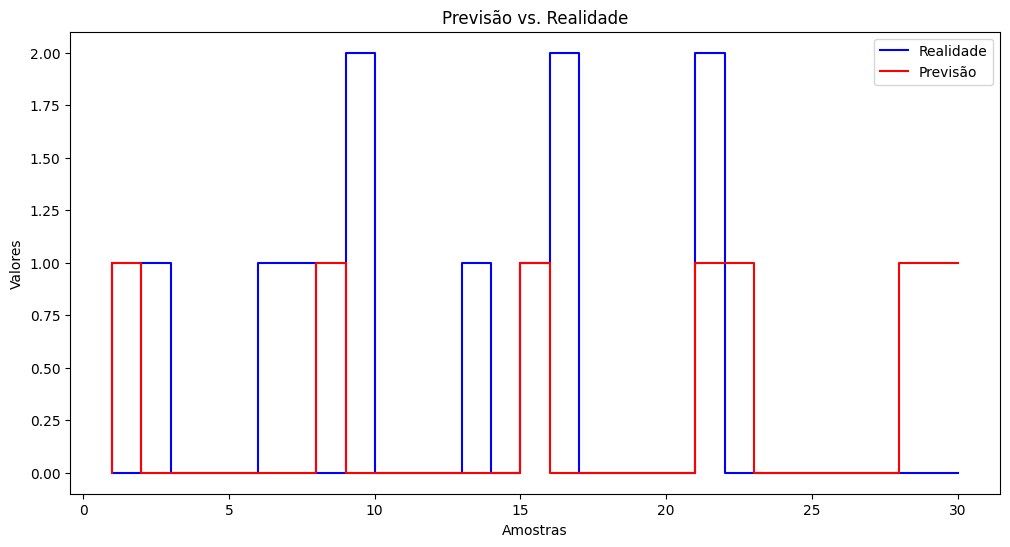

1/1 [==============================] - 0s 24ms/step


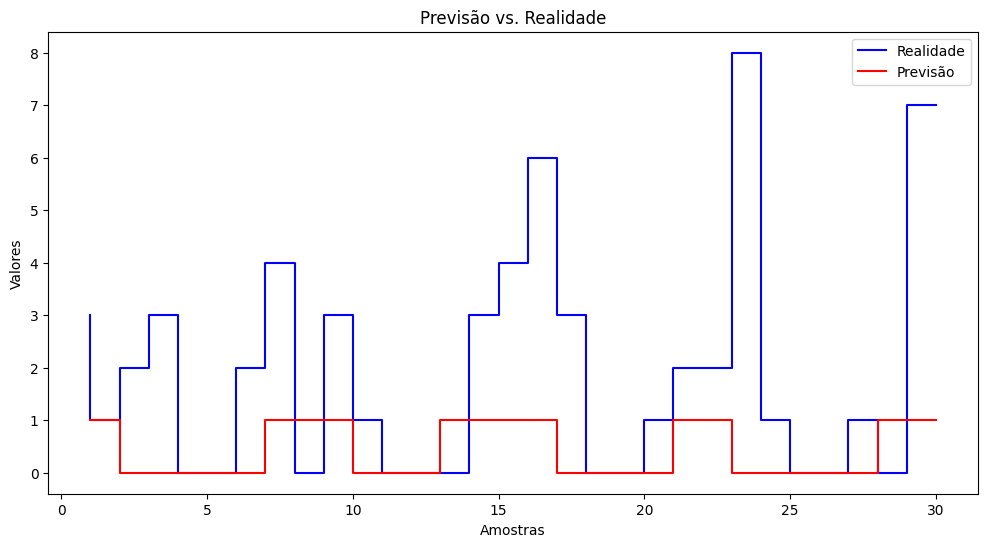

1/1 [==============================] - 0s 24ms/step


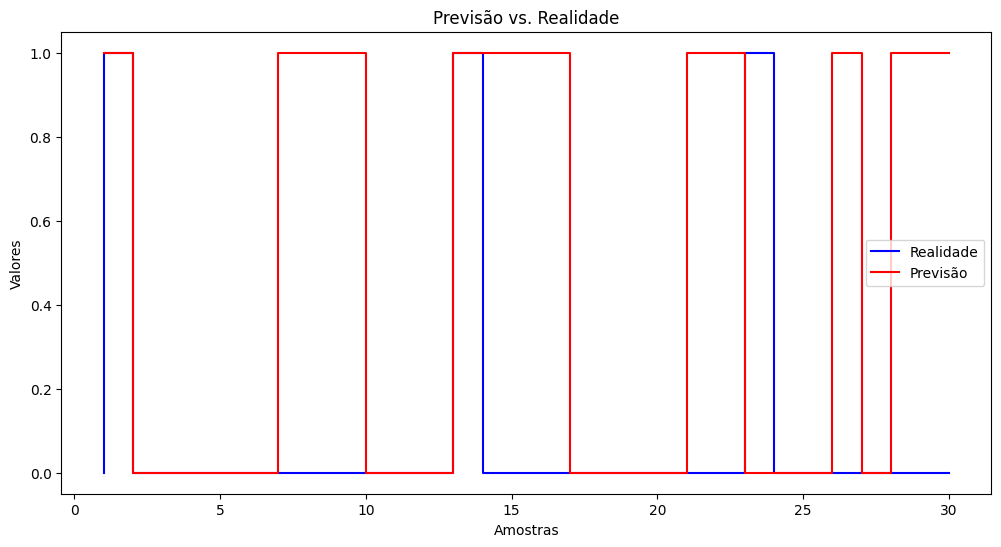

1/1 [==============================] - 0s 26ms/step


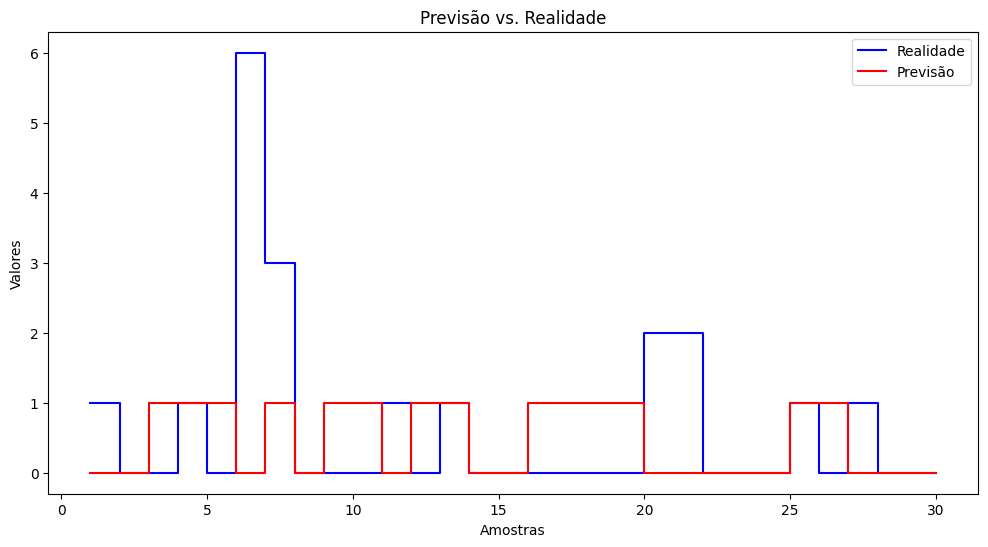

1/1 [==============================] - 0s 25ms/step


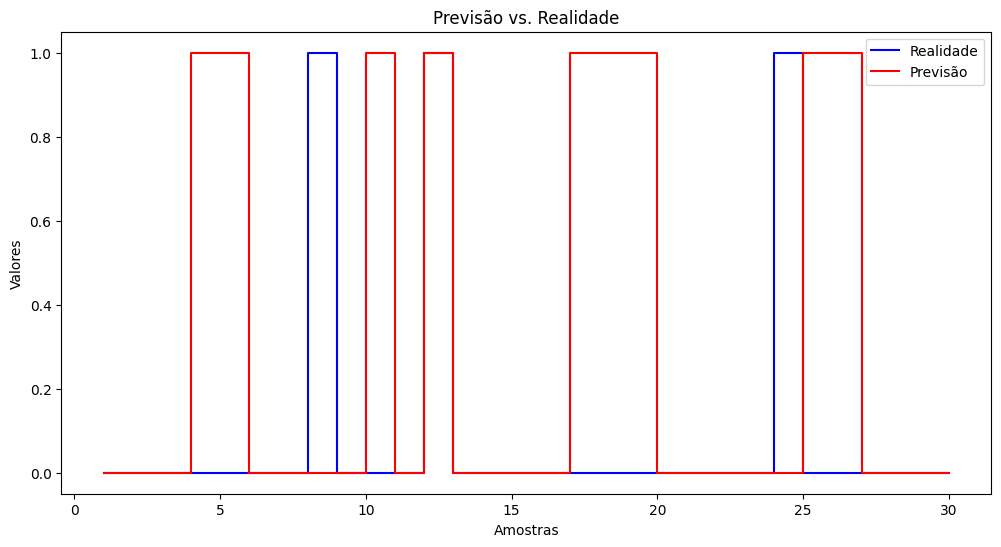

1/1 [==============================] - 0s 24ms/step


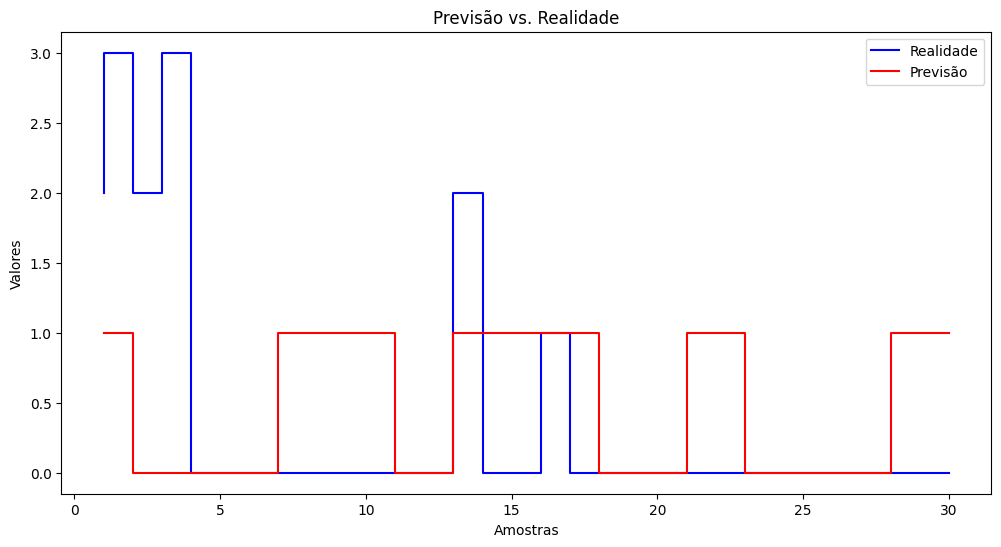

1/1 [==============================] - 0s 117ms/step


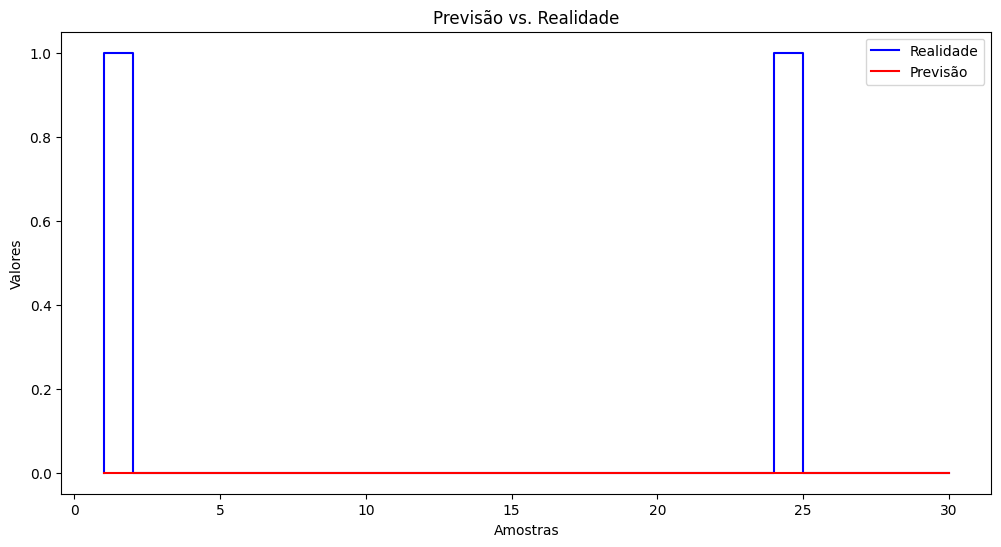

1/1 [==============================] - 0s 28ms/step


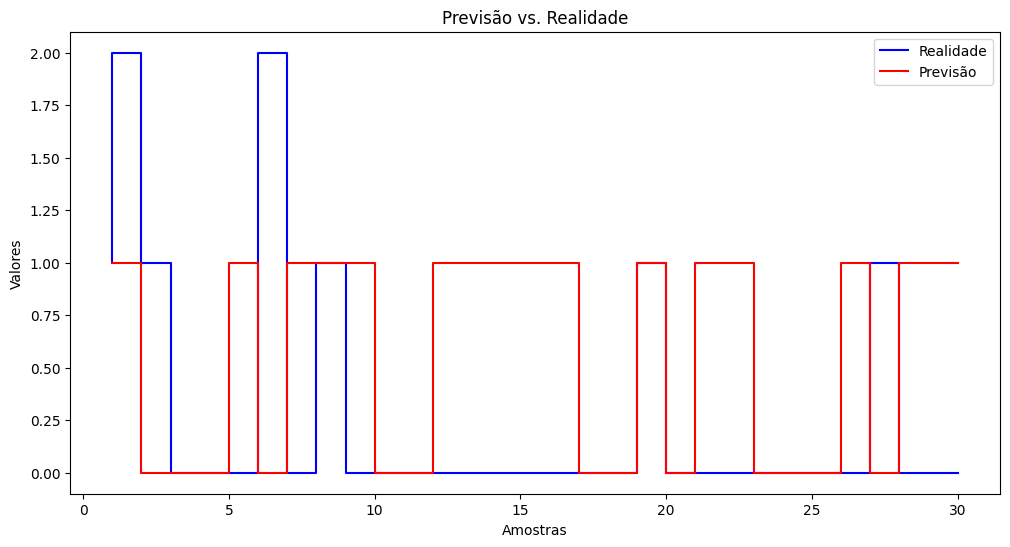

1/1 [==============================] - 0s 23ms/step


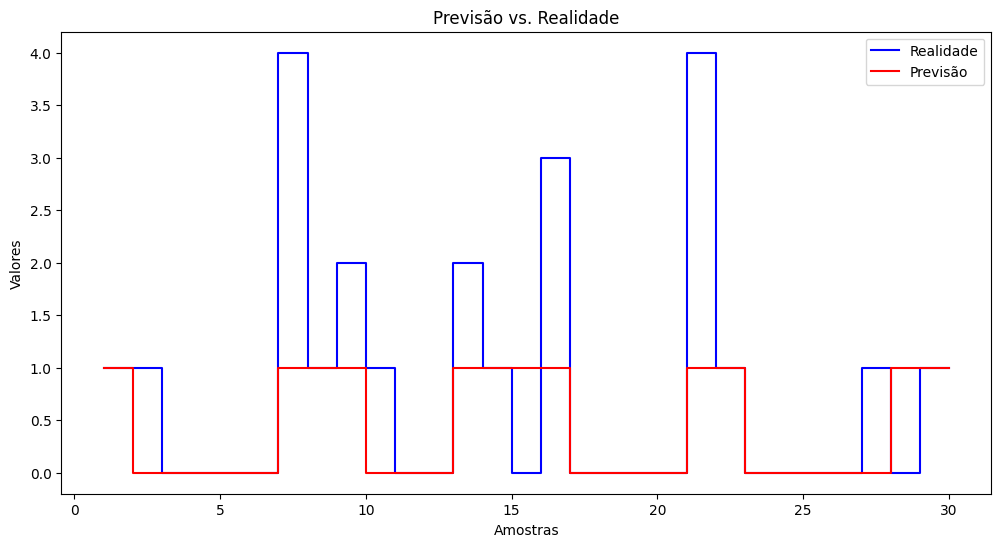

In [82]:
x = np.arange(n_steps_out)+1
for i in range(10):
    y_pred = model.predict(X_test[i].reshape((1, n_steps_in, n_features)))
    
    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.step(x, y_test[i].reshape(n_steps_out), label='Realidade', color='blue')
    plt.step(x, np.round(y_pred.reshape(n_steps_out)).astype(int), label='Previsão', color='red')
    plt.title('Previsão vs. Realidade')
    plt.xlabel('Amostras')
    plt.ylabel('Valores')
    plt.legend()
    plt.show()

In [75]:
y_pred.reshape(n_steps_out)

array([0.22232443, 0.23146701, 0.        , 0.12404554, 0.20773084,
       0.23808074, 0.        , 0.26022884, 0.23844013, 0.20956455,
       0.25186205, 0.        , 0.33814275, 0.29659066, 0.31350568,
       0.2567949 , 0.23882705, 0.25888166, 0.3195605 , 0.35818264,
       0.        , 0.34029528, 0.36853555, 0.        , 0.        ,
       0.35549557, 0.36584887, 0.        , 0.33625874, 0.28806433],
      dtype=float32)

In [80]:
np.arange(n_steps_out)+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## Draft

In [86]:
dataset_raw['requisicoes'].value_counts

<bound method IndexOpsMixin.value_counts of 0      1
1      3
2      1
3      2
4      1
      ..
699    1
700    1
701    1
702    2
703    2
Name: requisicoes, Length: 704, dtype: int64>